In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import re
import pandas as pd
import nltk
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
stopWords = set(stopwords.words('turkish'))
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/YapayZeka/train.csv', encoding= 'unicode_escape')
df_test = pd.read_csv('/content/drive/MyDrive/YapayZeka/test.csv', encoding= 'unicode_escape')

In [6]:
def pre_processing(text):
    text = text.lower()  # Büyük harften küçük harfe çevir
    text = re.sub("[^abcçdefgğhıijklmnoöprsştuüvyz]", " ", text)
    text = nltk.word_tokenize(text)
    text = [word for word in text if not word in stopWords]
    lemma = nltk.WordNetLemmatizer()
    text = [lemma.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

In [7]:
df_train["clean_text"] = df_train["comment"].apply(lambda x: pre_processing(x))
df_test["clean_text"] = df_test["comment"].apply(lambda x: pre_processing(x))


In [9]:
X_train = df_train["clean_text"]
X_test = df_test["clean_text"]
y_train = df_train["Label"]
y_test = df_test["Label"]

In [10]:
print("x_train", X_train.shape)
print("x_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

x_train (7996,)
x_test (2666,)
y_train (7996,)
y_test (2666,)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
# Modeli oluştur ve eğit
model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [13]:
# Modeli kaydet
with open('/content/drive/MyDrive/YapayZeka/logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [15]:
def plot_confusion_matrix(Y_test, Y_preds):
    conf_mat = confusion_matrix(Y_test, Y_preds)
    fig = plt.figure(figsize=(6,6))
    plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
    plt.yticks(range(2), range(2))
    plt.xticks(range(2), range(2))
    plt.colorbar()
    for i in range(2):
        for j in range(2):
            plt.text(i-0.2, j+0.1, str(conf_mat[j, i]), color='tab:red')

CV average score: 0.89
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1333
           1       0.90      0.88      0.89      1333

    accuracy                           0.89      2666
   macro avg       0.89      0.89      0.89      2666
weighted avg       0.89      0.89      0.89      2666

Train Accuracy : 0.952
Test Accuracy : 0.890
0.8902347849193588 : is the precision score
0.8900975243810954 : is the recall score
0.8900878593024191 : is the f1 score


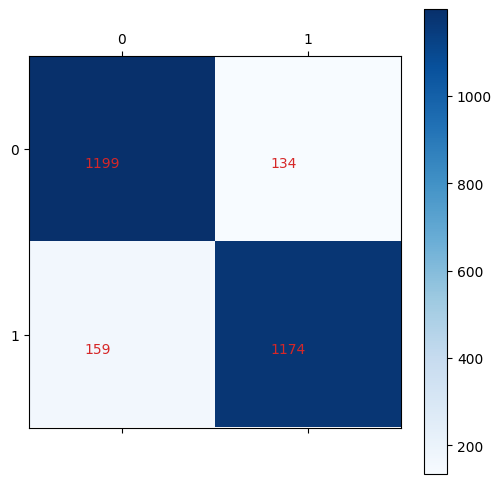

In [16]:
cv_scores = cross_val_score(model, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

result = model.predict(X_test)
cr = classification_report(y_test, result)
print(cr)

print('Train Accuracy : %.3f' % model.score(X_train, y_train))
print('Test Accuracy : %.3f' % model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(precision_score(y_test, y_pred, average='macro'), ": is the precision score")
print(recall_score(y_test, y_pred, average='macro'), ": is the recall score")
print(f1_score(y_test, y_pred, average='macro'), ": is the f1 score")

plot_confusion_matrix(y_test, model.predict(X_test))

In [17]:
from bs4 import BeautifulSoup

html_content = """
<div class="comment-content">
    <p>Bu film çok güzeldi, kesinlikle tavsiye ederim!</p>
</div>
<div class="comment-content">
    <p>Kötü oyunculuk, senaryo zayıf, beğenmedim.</p>
</div>
<div class="comment-content">
    <p>Mükemmel bir film, tekrar izleyeceğim!</p>
</div>
"""

soup = BeautifulSoup(html_content, 'html.parser')

comment_list = []
comments = soup.find_all("div", {"class": "comment-content"})

for comment in comments:
    comment_text = comment.find("p").text.strip()
    comment_list.append(comment_text)

# Çekilen yorumları ekrana yazdırma
for comment in comment_list:
    print(comment)




Bu film çok güzeldi, kesinlikle tavsiye ederim!
Kötü oyunculuk, senaryo zayıf, beğenmedim.
Mükemmel bir film, tekrar izleyeceğim!


In [18]:
# Modeli yükleme
with open('/content/drive/MyDrive/YapayZeka/logistic_regression_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# Yorumları işleyerek duygu analizi yapma
for comment in comment_list:
    processed_comment = pre_processing(comment)
    prediction = model.predict([processed_comment])
    probability = model.predict_proba([processed_comment])

    if prediction[0] == 1:
        print(comment, " is Positive with probability:", probability[0][1])
    else:
        print(comment, " is Negative with probability:", probability[0][0])

Bu film çok güzeldi, kesinlikle tavsiye ederim!  is Positive with probability: 0.9770379452691266
Kötü oyunculuk, senaryo zayıf, beğenmedim.  is Negative with probability: 0.9778184742571431
Mükemmel bir film, tekrar izleyeceğim!  is Positive with probability: 0.9857061387574537


In [19]:
# Manuel metin analizi
manuel_metin = input("Lütfen duygu analizi yapmak istediğiniz metni girin: ")

# Metnin duygu analizini yap
processed_manuel_metin = pre_processing(manuel_metin)
prediction = model.predict([processed_manuel_metin])
probability = model.predict_proba([processed_manuel_metin])

# Duygu analizinin sonuçlarını yazdır
if prediction[0] == 1:
    print("Girdiğiniz metin Pozitif duygu içeriyor. Olasılık: ", probability[0][1])
else:
    print("Girdiğiniz metin Negatif duygu içeriyor. Olasılık: ", probability[0][0])

Lütfen duygu analizi yapmak istediğiniz metni girin: nedense beğenemedim
Girdiğiniz metin Negatif duygu içeriyor. Olasılık:  0.760997796805265


In [20]:
import requests
from bs4 import BeautifulSoup

URL = "https://hdfilmcehennemi.cx/aquaman-ve-kayip-krallik/"
r = requests.get(URL)

soup = BeautifulSoup(r.content, 'html.parser')
print(soup.prettify())  # HTML yapısını kontrol edin

comment_list = []
comments = soup.find_all("div", {"class": "comment-content"})  # Örnek olarak yeni sınıf adı
print(f"Found {len(comments)} comments")  # Yorum sayısını kontrol edin

for comment in comments:
    comment_text = comment.find("p").text.strip()  # Yorumun olduğu etiket ve sınıf adı
    comment_list.append(comment_text)

# Çekilen yorumları ekrana yazdırma
for comment in comment_list:
    print(comment)



<!DOCTYPE html>
<html lang="tr" xmlns="http://www.w3.org/1999/xhtml">
 <head profile="http://gmpg.org/xfn/11">
  <style id="litespeed-ccss">
   body{color:#333;font-size:13px;font-weight:400;font-family:'Noto Sans',arial,serif;margin:0 auto 0px;padding:0;background-image:linear-gradient(to right,#444 0%,#323638 100%)}a,a:visited{font-size:12px;color:rgba(255,255,255,.8);text-decoration:none}a img{border:0}li{list-style:none}ul{list-style:none}ul a{color:#ccc}form.example{margin-bottom:-10px;margin-top:-10px}form.example input[type=text]{padding:10px 0;font-size:14px;border:0;float:left;width:85%;background:#f1f1f1;font-family:Poppins,arial,serif;background-color:rgba(0,0,0,.6);text-indent:12px;color:#fff;-webkit-appearance:none;border-radius:0}form.example button{float:left;width:15%;padding:10px;font-size:17px;border:0;border-left:none;background-color:rgba(0,0,0,.25);color:#fff;-webkit-appearance:none}form.example input[type=text]::-ms-input-placeholder{color:#ccc}form.example input[

In [ ]:
aaaaaaaa

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# KNN Modeli oluşturma
knn_model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', KNeighborsClassifier(n_neighbors=5))])

# Modeli eğitme
knn_model.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', KNeighborsClassifier())])

KNN CV average score: 0.58
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.99      0.69      1333
           1       0.90      0.11      0.19      1333

    accuracy                           0.55      2666
   macro avg       0.71      0.55      0.44      2666
weighted avg       0.71      0.55      0.44      2666

KNN Train Accuracy : 0.996
KNN Test Accuracy : 0.547
0.7114997474061531 : is the precision score
0.5468867216804201 : is the recall score
0.4374210859137264 : is the f1 score


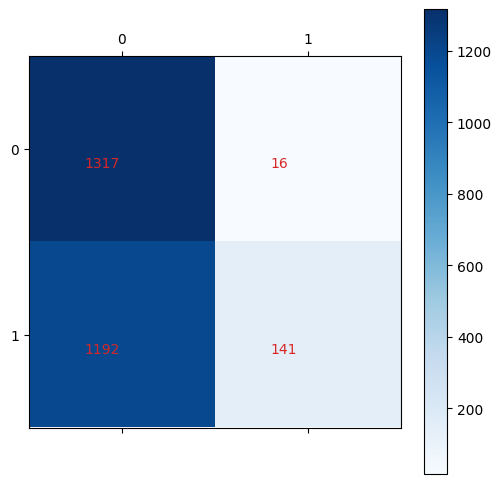

In [22]:
# Çapraz doğrulama skoru
cv_scores_knn = cross_val_score(knn_model, X_train, y_train, cv=10)
print("KNN CV average score: %.2f" % cv_scores_knn.mean())

# Test verileri üzerinde tahmin yapma
y_pred_knn = knn_model.predict(X_test)

# Değerlendirme metrikleri
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print('KNN Train Accuracy : %.3f' % knn_model.score(X_train, y_train))
print('KNN Test Accuracy : %.3f' % knn_model.score(X_test, y_test))
print(precision_score(y_test, y_pred_knn, average='macro'), ": is the precision score")
print(recall_score(y_test, y_pred_knn, average='macro'), ": is the recall score")
print(f1_score(y_test, y_pred_knn, average='macro'), ": is the f1 score")

# Karışıklık Matrisi Görselleştirmesi
def plot_confusion_matrix(Y_test, Y_preds):
    conf_mat = confusion_matrix(Y_test, Y_preds)
    fig = plt.figure(figsize=(6,6))
    plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
    plt.yticks(range(2), range(2))
    plt.xticks(range(2), range(2))
    plt.colorbar()
    for i in range(2):
        for j in range(2):
            plt.text(i-0.2, j+0.1, str(conf_mat[j, i]), color='tab:red')

plot_confusion_matrix(y_test, y_pred_knn)
plt.show()


In [24]:
# Yorumları işleyerek duygu analizi yapma
print("\nKNN Model ile Yorum Analizi Sonuçları:\n")
for comment in comment_list:
    processed_comment = pre_processing(comment)
    prediction = knn_model.predict([processed_comment])
    probability = knn_model.predict_proba([processed_comment])

    if prediction[0] == 1:
        print(comment, " is Positive with probability:", probability[0][1])
    else:
        print(comment, " is Negative with probability:", probability[0][0])



KNN Model ile Yorum Analizi Sonuçları:



In [26]:
# Manuel metin analizi
manuel_metin = input("Lütfen duygu analizi yapmak istediğiniz metni girin: ")

# Metnin duygu analizini yap
processed_manuel_metin = pre_processing(manuel_metin)
prediction = knn_model.predict([processed_manuel_metin])
probability = knn_model.predict_proba([processed_manuel_metin])

# Duygu analizinin sonuçlarını yazdır
if prediction[0] == 1:
    print("Girdiğiniz metin Pozitif duygu içeriyor. Olasılık: ", probability[0][1])
else:
    print("Girdiğiniz metin Negatif duygu içeriyor. Olasılık: ", probability[0][0])


Lütfen duygu analizi yapmak istediğiniz metni girin: kötü bir film
Girdiğiniz metin Negatif duygu içeriyor. Olasılık:  1.0
